In [1]:
import os
from importlib.resources import files
import time

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 7  # Total number of trajectories
num_train = 3 # Number of trajectories used for training
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 2))
train_y = np.empty((0, 2))
test_x = np.empty((0, 2))
test_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")

    # remove last point
    data = data[:-1,:]

    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)

    # center
    data[idx,:2] -= data[-1,:2]
    
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    
    # add to datset
    if i <= num_train:
        train_x = np.append(train_x, data[idx,:2], axis=0)
        train_y = np.append(train_y, data[idx,2:4], axis=0)
    else:
        test_x = np.append(test_x, data[idx,:2], axis=0)
        test_y = np.append(test_y, data[idx,2:4], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [4]:
torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)
# stiffness = Spherical()
# stiffness = Spherical(eval=2.0, grad=False)

attractor = train_x[-1][:2].detach()

model = FirstGeometry(embedding, attractor, stiffness,).to(device)
# TorchHelper.set_zero(model)
TorchHelper.load(model, '../outputs/synthetic_1_spd')

## Train

## Plot

In [5]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [6]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

# evals = stiffness.eigval.data.exp()
# evecs = stiffness.eigvec.data
# U, _ = torch.linalg.qr(torch.cat((evecs.unsqueeze(1), torch.rand(evecs.shape[0], evecs.shape[0]-1).to(device)), dim=1))
# stiffness_ellipse = torch.stack((evals[0]*theta.cos(), evals[1]*theta.sin()), dim=1)
# stiffness_ellipse = torch.mm(U, stiffness_ellipse.T).T.detach().cpu()/25
# print("Stiffness Evals: ", evals)
# print("Stiffness Evecs: ", evecs)

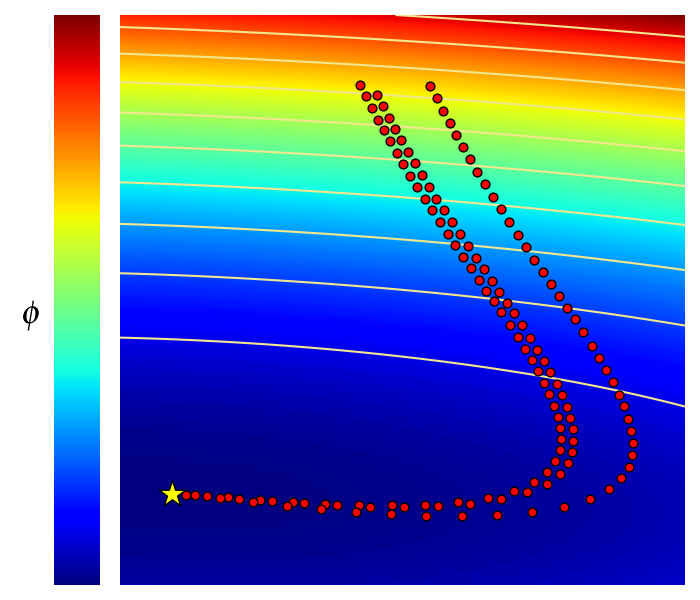

In [7]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
# ax.plot(stiffness_ellipse[:,0], stiffness_ellipse[:,1], c='k')

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential_first.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field & Streamlines 

In [8]:
from learn_embedding.utils.metrics import metric_exp

obstacle_radius = 0.05 # 0.05 , 0.1
obstacle = torch.tensor([[0.25,0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
# embedding.local_deformation = KernelDeformation(obstacle.to(device), weights=torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# embedding.metric = lambda y : metric_exp(y, embedding(obstacle.to(device)).squeeze(), sigma=lengthscale, eta=1.0)


field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

# # x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
# streamlines = Integrator.first_order(dynamics=model,x0=x0,T=20.0, dt=0.01).cpu().detach().numpy()

x0 = np.empty((0, 2))
for i in range(num_train + 1, num_traj + 1):
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    data = data[:-1,:]
    data[:,:2] -= data[-1,:2]
    x0 = np.append(x0, data[0,:2][np.newaxis, :], axis=0)
x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=20.0, dt=0.01).cpu().detach().numpy()

ValueError: 'y' values must be equally spaced

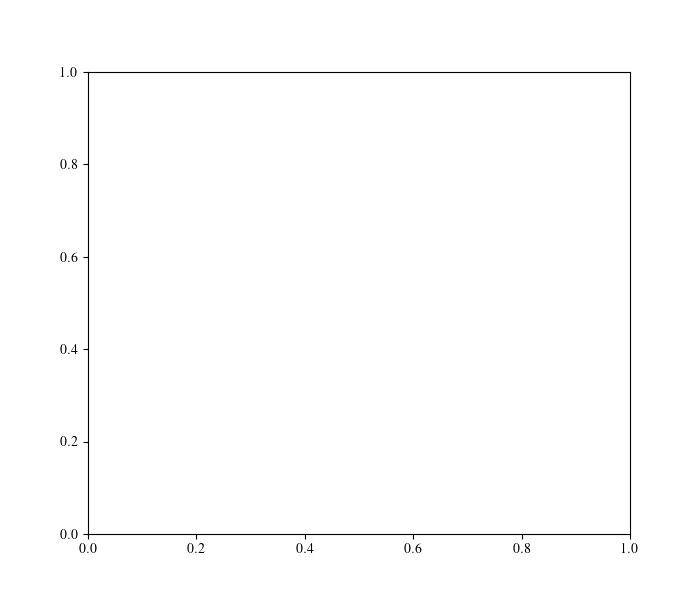

In [9]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)

if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius-0.02,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field_first.png', format='png', dpi=300, bbox_inches="tight") 

### Embedding

In [10]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

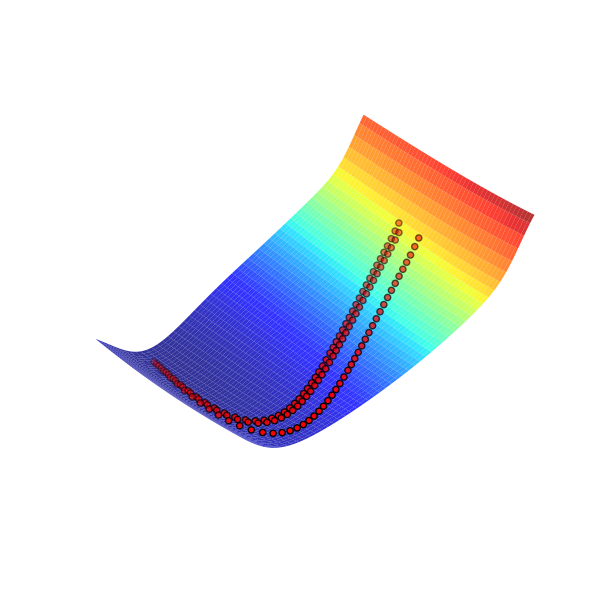

In [11]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))

im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=30, azim=-30)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding_first.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [12]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

x_range = (max_ax[0] - min_ax[0]).abs()
y_range = (max_ax[1] - min_ax[1]).abs()
evals /= 500*torch.tensor([y_range/x_range/10,1.0]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

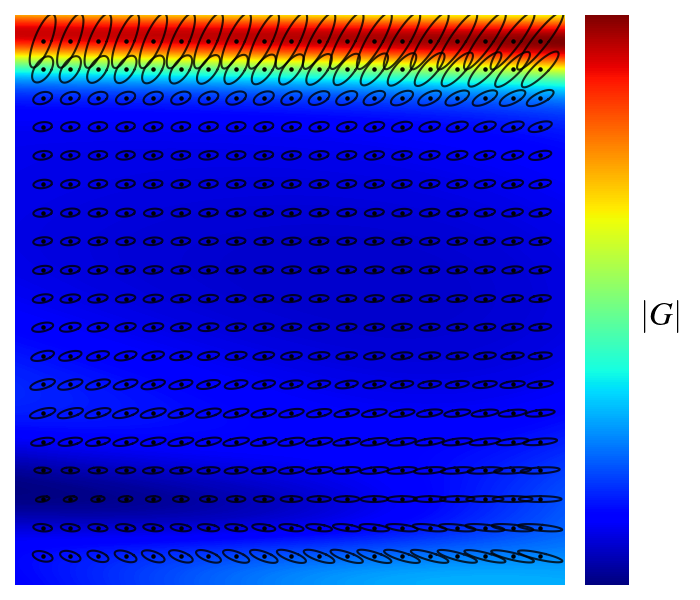

In [13]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric_first.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [14]:
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())

x_range = (max_ax[0] - min_ax[0]).abs()
y_range = (max_ax[1] - min_ax[1]).abs()
metric_evals/= 100*torch.tensor([y_range/x_range/10,1.0]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

In [15]:
x_range

tensor(0.3965, device='cuda:0')

In [16]:
y_range

tensor(1.2418, device='cuda:0')

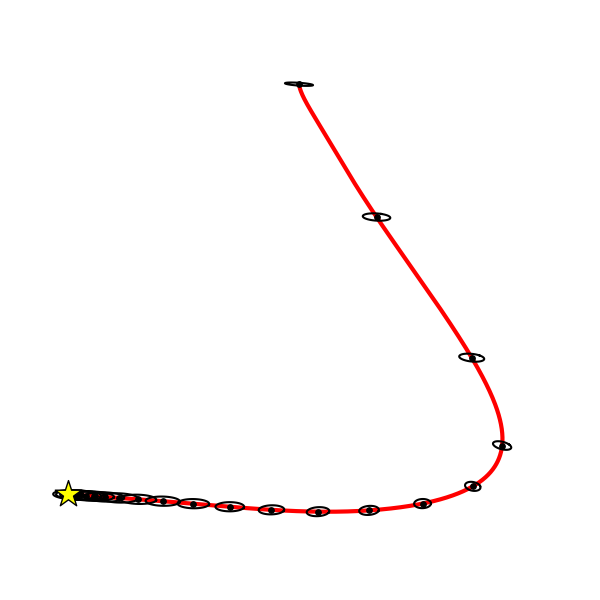

In [17]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 100
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric_first.png', format='png', dpi=300, bbox_inches="tight")

In [59]:
import pyvista as pv
n = 150000
uniform_grid = 2.0*torch.rand(n, 2).to(device).requires_grad_(True)-1.0
points = np.unique(embedding(uniform_grid).detach().cpu().numpy(), axis=0)
cloud = pv.PolyData(points)
mesh = cloud.delaunay_2d(alpha=0.4)
pv.save_meshio("mesh.obj", mesh)

# # Plot the mesh
# plotter = pv.Plotter()
# plotter.add_mesh(mesh, color='white')
# plotter.show()

potential = model.potential(torch.from_numpy(points[:,:2]).float().to(device).requires_grad_(True)).cpu().detach().numpy()
potential -= potential.min()
potential /= potential.max()

np.savetxt('mesh_points.csv', mesh.points)
np.savetxt('mesh_faces.csv', np.reshape(mesh.faces, (-1, 4))[:,1:])
np.savetxt('mesh_values.csv', potential/2)